<a href="https://colab.research.google.com/github/yimingm/MSSP608-Practical-Machine-Learning/blob/master/Yiming_Ma_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codebook Introduction

- The first section of the codebook contains packages that were used in this project and the upload of the data. The raw dataset can be acquired from this link https://www.ndacan.acf.hhs.gov/datasets/dataset-details.cfm?ID=98

  In this codebook, the data can be automatically imported and read by '!wget' for convenience. After importing the data, each columns were renamed to a more understandable format and are ready to use.

- The primary task contains five sections: descriptive analysis, initial model training, optimization, summary of final model, and error analysis.

- The extension task conduct a fairness audit. The fairness of the dataset was examined by three methods and showed by statistics and graphs.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import itertools
import seaborn as sn

import calendar
import statsmodels.formula.api as smf
from scipy import stats
from matplotlib import dates

from datetime import datetime
from datetime import timedelta
from matplotlib.dates import DateFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Upload and read the data

In [ ]:
!wget --no-check-certificate 'https://doc.google.com/uc?export=download&id=1UFxsd5QR4Cbgxr1vk2enNf4d4QmQwJw4' -O abuse.csv

--2020-05-09 02:53:30--  https://doc.google.com/uc?export=download&id=1UFxsd5QR4Cbgxr1vk2enNf4d4QmQwJw4
Resolving doc.google.com (doc.google.com)... 108.177.12.101, 108.177.12.113, 108.177.12.139, ...
Connecting to doc.google.com (doc.google.com)|108.177.12.101|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://docs.google.com/uc?export=download&id=1UFxsd5QR4Cbgxr1vk2enNf4d4QmQwJw4 [following]
--2020-05-09 02:53:30--  https://docs.google.com/uc?export=download&id=1UFxsd5QR4Cbgxr1vk2enNf4d4QmQwJw4
Resolving docs.google.com (docs.google.com)... 173.194.216.102, 173.194.216.113, 173.194.216.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.216.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8o37r0hvd8t5goc6f60nm1dkqncsoj92/1588992750000/04766574434707070898/*/1UFxsd5QR4Cbgxr1vk2enNf4d4QmQwJ

In [ ]:
# Import dataset
abuse = pd.read_csv("abuse.csv")
abuse.columns

Index(['staterr', 'rptdt', 'rpdispdt', 'rptsrc', 'chage', 'chsex', 'chrace',
       'chprior', 'famsup', 'fostercr', 'fl_cvphy', 'fl_cvneg', 'fl_cvsex',
       'fl_cvpsy', 'cdalcdru', 'cdphysme', 'fcalcdru', 'fcphysme', 'fchouse',
       'fcmoney', 'fcpublic'],
      dtype='object')

In [ ]:
# Rename columns
abuse.rename(
    columns={
        "staterr": "state",
        "rptdt": "report_date",
        "rpdispdt": "disposition_date",
        "rptsrc": "report_source",
        "chage": "age",
        "chsex": "sex",
        "chrace": "race",
        "chprior": "prior_vic",
        "famsup": "fam_support",
        "fostercr": "foster_service",
        "fl_cvphy": "physical_abuse",
        "fl_cvneg": "neglect",
        "fl_cvsex": "sexual_abuse",
        "fl_cvpsy": "phycological_abuse",
        "cdalcdru": "child_drug_alcohol",
        "cdphysme": "child_mental_physical",
        "fcalcdru": "care_drug_alcohol",
        "fcphysme": "care_mental_physical",
        "fchouse": "house_problem",
        "fcmoney": "financial_problem",
        "fcpublic": "pub_assistance"
    },
    inplace=True
)
abuse.columns

Index(['state', 'report_date', 'disposition_date', 'report_source', 'age',
       'sex', 'race', 'prior_vic', 'fam_support', 'foster_service',
       'physical_abuse', 'neglect', 'sexual_abuse', 'phycological_abuse',
       'child_drug_alcohol', 'child_mental_physical', 'care_drug_alcohol',
       'care_mental_physical', 'house_problem', 'financial_problem',
       'pub_assistance'],
      dtype='object')

# Primary task - Exploratory Data Analysis
This part contains descriptive analysis of the following features:
- Risk Level (outcome variable)
- report/disposition date
- report source
- age
- race
- prior maltreatment
- type of maltreatment
- child's issue/family issue

In [ ]:
# Generate outcome variable "risk_level"
def risk_level(x, y):
    if x == 1 :
        return "high"
    if x == 2 and y == 2:
        return "low"
    if x == 2 and y == 1:
        return "high"
    
abuse["risk_level"] = abuse.apply(lambda row: risk_level(row["foster_service"], row["fam_support"]), axis=1)
print(abuse["risk_level"].value_counts())
# abuse.head()

low     23274
high     7141
Name: risk_level, dtype: int64


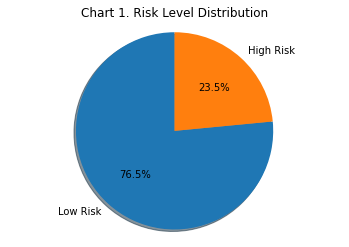

In [ ]:
# Use pie chart to present distribution of risk level

labels = 'Low Risk', 'High Risk'
sizes = [23274, 7141]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Chart 1. Risk Level Distribution') 
plt.show()

In [ ]:
# Distribution of age
print(abuse["age"].value_counts())

0     3056
5     2127
7     2101
6     2079
2     2019
3     1968
4     1952
8     1949
1     1827
9     1757
10    1643
11    1463
12    1391
13    1350
14    1315
15    1117
16     870
17     408
18      19
19       2
21       1
20       1
Name: age, dtype: int64


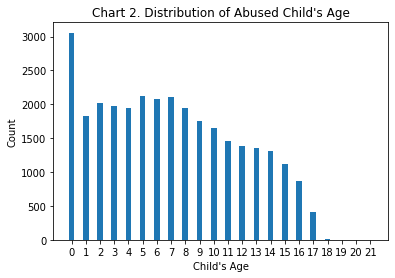

In [ ]:
# Use bar chart to present distribution of age

left = [1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] 
# heights of bars 
height = [3056, 1827, 2019, 1968, 1952, 2127, 2079, 2101, 1949, 1757, 1643, 1463, 1391, 1350, 1315, 1117, 870, 408, 19, 2, 1,1]
# labels for bars 
tick_label = [0,1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4) 
 
plt.xlabel("Child's Age") 
plt.ylabel('Count') 
plt.title("Chart 2. Distribution of Abused Child's Age") 
plt.show() 

In [ ]:
# Distribution of race
# 1 - White
# 2 - Black
# 3 - Native
# 4 - Asian
print(abuse["race"].value_counts())

1    20701
2     9363
4      203
3      148
Name: race, dtype: int64


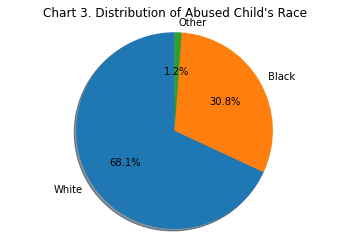

In [ ]:
# Distribution of Race ('Other' represents 'native' and 'asian')
labels = 'White', 'Black', 'Other'
sizes = [20701, 9363, 351]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title("Chart 3. Distribution of Abused Child's Race") 
plt.show()

In [ ]:
# Distribution of maltreatment
# 0 - no maltreatment
# 1 - this maltreatment happened
print(abuse["physical_abuse"].value_counts())
print(abuse["neglect"].value_counts())
print(abuse["sexual_abuse"].value_counts())
print(abuse["phycological_abuse"].value_counts())

0    21324
1     9091
Name: physical_abuse, dtype: int64
1    18185
0    12230
Name: neglect, dtype: int64
0    26708
1     3707
Name: sexual_abuse, dtype: int64
0    29267
1     1148
Name: phycological_abuse, dtype: int64


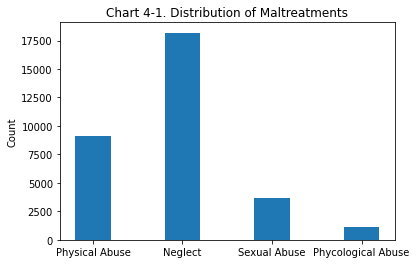

In [ ]:
# Use bar chart to present the distribution of maltreatment

left = [1, 2, 3, 4] 
# heights of bars 
height = [9091, 18185, 3707, 1148]  
# labels for bars 
tick_label = ['Physical Abuse', 'Neglect', 'Sexual Abuse', 'Phycological Abuse'] 
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4) 

# naming the graph 
plt.ylabel('Count') 
plt.title('Chart 4-1. Distribution of Maltreatments') 
plt.show() 

In [ ]:
# Distribution of report source
# 1 Social Services/Mental Health 
# 2 Medical Personnel 
# 3 Legal Personnel 
# 4 Educational Personnel 
# 5 Care Provider/Foster Parent 
# 6 Alleged Victim
# 7 Parent 
# 8 Other Relative 
# 9 Friends Neighbor 
# 10 Alleged Perpetrator 
# 11 Anonymous Reporter 
print(abuse["report_source"].value_counts())

3     6242
4     4411
9     4248
8     3677
2     3455
7     3007
1     2337
11    2190
6      420
5      346
10      82
Name: report_source, dtype: int64


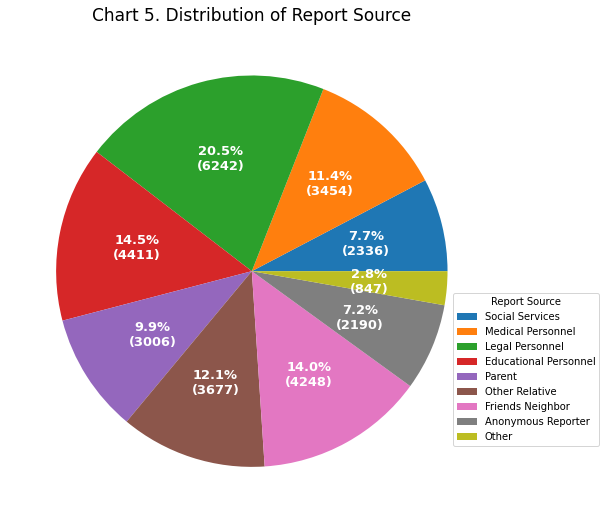

In [ ]:
# Use pie chart to present the distribution of report source

fig, ax = plt.subplots(figsize=(10, 9), subplot_kw=dict(aspect="equal"))

# Assign labels and size of each slices
labels = 'Social Services', 'Medical Personnel', 'Legal Personnel', 'Educational Personnel', 'Parent', 'Other Relative', 'Friends Neighbor', 'Anonymous Reporter','Other'
sizes = [2337, 3455, 6242, 4411, 3007, 3677, 4248, 2190, 848]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(sizes, autopct=lambda pct: func(pct, sizes),
                                  textprops=dict(color="w"))
# Add legend to the side
ax.legend(wedges, labels,
          title="Report Source",
          loc="center left",
          bbox_to_anchor=(0.9, 0.05, 0.5, 0.5))

plt.setp(autotexts, size=13, weight="bold")

ax.set_title("Chart 5. Distribution of Report Source",size = 17)

plt.show()

In [ ]:
# Distribution of report date/disposition date
# Generate report month/disposition month
# Use month to represent date for convenience
abuse['report_date'] = pd.to_datetime(abuse['report_date'])
abuse['report_month'] = abuse['report_date'].dt.month
abuse['report_month_str'] = abuse['report_date'].dt.strftime('%b')

In [ ]:
print(abuse["report_month_str"].value_counts())
print(abuse["report_month_str"].unique())

Aug    2871
Oct    2645
Sep    2639
Mar    2630
Apr    2626
May    2618
Jan    2594
Jul    2550
Feb    2486
Jun    2400
Nov    2230
Dec    2126
Name: report_month_str, dtype: int64
['Mar' 'Sep' 'May' 'Jan' 'Aug' 'Apr' 'Jun' 'Jul' 'Dec' 'Feb' 'Oct' 'Nov']


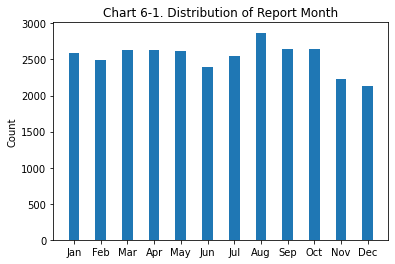

In [ ]:
# The distribution of report month

left = [1, 2, 3, 4,5,6,7,8,9,10,11,12] 
# heights of bars 
height = [2594, 2486, 2630, 2626, 2618, 2400, 2550, 2871, 2639, 2645, 2230, 2126]  
# labels for bars 
tick_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] 
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4) 

plt.ylabel('Count') 
plt.title('Chart 6-1. Distribution of Report Month') 
plt.show() 

# Primary task - Model Training
**Dataset set up**

Before training any model, the dataset was divided into three subsets:

Training 80%/ Development 10%/ Test Sets 10%

The 10% test set was not used until the final model.

**Build Decision Tree**

The initial model adopt decision tree to be the classifier. The following codes trained the decision tree and provided the performance (accuracy, kappa, precision, and recall) of the trained classifier using scikit-learn. 

In [ ]:
# The initial model includes all selected features
# Build up feature set
state = ["state"]
report_month = ["report_month"]
report_source = ['report_source']
age = ['age']
sex = ['sex']
race = ['race']
prior = ['prior_vic']
physical_abuse = ['physical_abuse']
neglect = ['neglect']
sexual_abuse = ['sexual_abuse']
phycological_abuse = ['phycological_abuse']
child_drug_alcohol = ['child_drug_alcohol']
child_mental_physical = ['child_mental_physical'] 
care_drug_alcohol = ['care_drug_alcohol']
care_mental_physical = ['care_mental_physical']
house_problem = ['house_problem']
financial_problem = ['financial_problem']
pub_assistance = ['pub_assistance']

all_feature = state + report_month + report_source + age + sex + race + prior + physical_abuse + neglect + sexual_abuse + phycological_abuse + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance


In [ ]:
# Use train_test_split twice to split the dataset into three sets
# 80% train/10% dev/10% test
X = abuse.loc[:, all_feature]
X = pd.get_dummies(X)
y = abuse["risk_level"]

# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 

In [ ]:
# The first model train on train_set and test on dev_set
model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    
# List of initial hyperparameter settings
print(model)
    
# Calculate our accuracy, kappa and precision on the train and dev sets
y_pred = model.predict(X_dev)

accuracy = 100*accuracy_score(y_dev, y_pred)
kappa = cohen_kappa_score(y_dev, y_pred)
precision = precision_score(y_dev, y_pred, pos_label= "high")
recall = recall_score(y_dev, y_pred, pos_label= "high")

# The printed result includes performance of the feature set and the confusion matrix
print(f"Results for the first model:")
print(confusion_matrix(y_dev, y_pred))
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
print("------------------------")


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Results for the first model:
[[ 320  415]
 [ 442 1865]]
Accuracy: 71.8 Kappa: 0.241 Precision: 0.420 Recall: 0.435
------------------------


# Primary task - Optimization

## **Optimization 1: Adjust features in the model**

**Step 1**: Use report_date and disposition_date to generate a new variable: **process_time**, it represents how many days did it take to process a case.

**Step 2**: Combine 4 binary features from case result (physical abuse, neglect, sexual abuse, phycological abuse) into one. The new case result feature has four labels: singel abuse, double abuse, triple abuse, quad abuse.

**Step 3**: Transform age (0-21) to age group (infant, 1-7, 8-16, 16-21).

**Step 4**: Remove some features too see if the performance get better. By removing **sex** , **age** and **prior**, the model get higher performance.


To conlcude, the following changes improved the performance:
 - adding **process_time**
 - delete **sex** , **age** and **prior**
 - adopt **case_result** instead of four seperate binary features (physical_abuse, neglect, sexual abuse, phycological abuse)

The performance of the model was improved in opt1:
 - accuracy: 73.3 to 82.9
 - Kappa: 0.268 to 0.533
 - precision: 0.435 to 0.628
 - recall: 0.452 to 0.666

### Step 1: process time

In [ ]:
# Step 1
# Generate processing time (from report date to disposition date)
date = pd.DataFrame(columns=["report_date", "disposition_date"])

date.report_date = abuse['report_date']
date.report_date = pd.to_datetime(date.report_date)

date.disposition_date = abuse['disposition_date']
date.disposition_date = pd.to_datetime(date.disposition_date)

difference = (date.disposition_date - date.report_date)

abuse['process_time'] = difference / timedelta (days=1)
# print(abuse)

In [ ]:
# transform process time to group
def process_time_group(x):
    if x <= 30:
        return "<1 month"
    if x > 30 and x <= 90:
        return "1-3 month"
    if x > 90 and x <= 180:
        return "3-6 month"
    if x > 180 and x <= 365:
        return "6-12 month"
    if x > 365:
        return ">1 year"
    
abuse["process_time_group"] = abuse["process_time"].apply(process_time_group)
abuse["process_time_group"].value_counts()

<1 month      14223
1-3 month     11628
3-6 month      3258
6-12 month     1026
>1 year         280
Name: process_time_group, dtype: int64

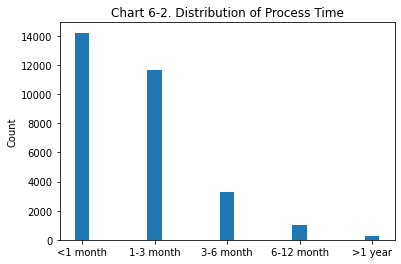

In [ ]:
# Distribution of Risk Level
left = [1, 2, 3, 4, 5] 
# heights of bars 
height = [14223, 11628, 3258, 1026, 280]  
# labels for bars 
tick_label = ['<1 month', '1-3 month', '3-6 month', '6-12 month', '>1 year'] 
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.2) 

plt.ylabel('Count') 
plt.title("Chart 6-2. Distribution of Process Time") 
plt.show() 

In [ ]:
# Add process_time to the feature set
process_time = ['process_time']
all_feature_with_process_time = state + report_month + process_time + report_source + age + sex + race + prior + physical_abuse + neglect + sexual_abuse + phycological_abuse + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

In [ ]:
# With the new feature, train the model again to see how performace change

# Create a dummyset with only the features in our feature set
X = abuse.loc[:, all_feature_with_process_time]
X = pd.get_dummies(X)

y = abuse["risk_level"]

# This model still train on train_set and test on dev_set
# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 
model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    
# List of hyperparameter settings
print(model)
    
# Calculate our accuracy, kappa and precision on the train and dev sets
y_pred = model.predict(X_dev)

accuracy = 100*accuracy_score(y_dev, y_pred)
kappa = cohen_kappa_score(y_dev, y_pred)
precision = precision_score(y_dev, y_pred, pos_label= "high")
recall = recall_score(y_dev, y_pred, pos_label= "high")
    
# The printed result includes performance of the feature set and the confusion matrix
print(f"Results for model with process_time:")
print(confusion_matrix(y_dev, y_pred))
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Results for model with process_time:
[[ 396  339]
 [ 354 1953]]
Accuracy: 77.2 Kappa: 0.383 Precision: 0.528 Recall: 0.539


### Step 2: case result

In [ ]:
# Step 2
# Transform case result features
# Generate "case_result" and present the distribution
def case_result(a, b, c, d):
    if a == 1 and b == 0 and c == 0 and d == 0:
        return "single_abuse"
    if a == 0 and b == 1 and c == 0 and d == 0:
        return "single_abuse"
    if a == 0 and b == 0 and c == 1 and d == 0:
        return "single_abuse"
    if a == 0 and b == 0 and c == 0 and d == 1:
        return "single_abuse"
    if a == 1 and b == 1 and c == 1 and d == 1:
        return "quad_abuse"
    if a == 0 and b == 1 and c == 1 and d == 1:
        return "triple_abuse"
    if a == 1 and b == 0 and c == 1 and d == 1:
        return "triple_abuse"
    if a == 1 and b == 1 and c == 0 and d == 1:
        return "triple_abuse"
    if a == 1 and b == 1 and c == 1 and d == 0:
        return "triple_abuse"
    else:
        return "double_abuse"
    
abuse["case_result"] = abuse.apply(lambda row: case_result(row["physical_abuse"], row["sexual_abuse"], row["phycological_abuse"], row["neglect"]), axis=1)
print(abuse["case_result"].value_counts())

single_abuse    27403
double_abuse     2868
triple_abuse      140
quad_abuse          4
Name: case_result, dtype: int64


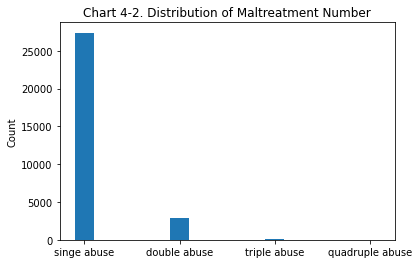

In [ ]:
# Use bar chart to present the distribution of case_result
left = [1, 2, 3, 4] 
height = [27403, 2868, 140, 4]  
# labels for bars 
tick_label = ['singe abuse', 'double abuse', 'triple abuse', 'quadruple abuse'] 
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, 
        width = 0.2) 

plt.ylabel('Count') 
plt.title("Chart 4-2. Distribution of Maltreatment Number") 
plt.show() 

In [ ]:
# Add case result to the feature set
case_result = ['case_result']
all_feature_time_case = state + report_month + process_time + report_source + age + sex + race + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

In [ ]:
# With the new feature, train the model again to see how performance change

# Create a dummyset with only the features in our feature set
X = abuse.loc[:, all_feature_time_case]
X = pd.get_dummies(X)

y = abuse["risk_level"]

# This model still train on train_set and test on dev_set
# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 
model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    
# List of hyperparameter settings
print(model)
    
# Calculate our accuracy, kappa and precision on the train and dev sets
y_pred = model.predict(X_dev)

accuracy = 100*accuracy_score(y_dev, y_pred)
kappa = cohen_kappa_score(y_dev, y_pred)
precision = precision_score(y_dev, y_pred, pos_label= "high")
recall = recall_score(y_dev, y_pred, pos_label= "high")
    
# The printed result includes performance of the feature set and the confusion matrix
print(f"Results for model with process_time and case_result:")
print(confusion_matrix(y_dev, y_pred))
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Results for model with process_time and case_result:
[[ 392  343]
 [ 369 1938]]
Accuracy: 76.6 Kappa: 0.369 Precision: 0.515 Recall: 0.533


### Step 3: age

In [ ]:
# Step 3
# transform age to age group
def age_group(x):
    if x == 0:
        return "infant"
    if x > 0 and x < 8:
        return "1-7"
    if x > 7 and x < 17:
        return "8-16"
    if x > 16:
        return ">16"
    
abuse["age_group"] = abuse["age"].apply(age_group)
abuse["age_group"].value_counts()

1-7       14073
8-16      12855
infant     3056
>16         431
Name: age_group, dtype: int64

In [ ]:
# Replace age by age_group
age_group = ['age_group']
all_feature_time_case_age = state + report_month + process_time + report_source + age_group + sex + race + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

In [ ]:
# With the new feature, train the model again to see how performance change

# Create a dummyset with only the features in our feature set
X = abuse.loc[:, all_feature_time_case_age]
X = pd.get_dummies(X)

y = abuse["risk_level"]

# This model still train on train_set and test on dev_set
# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 
model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    
# List of hyperparameter settings
print(model)
    
# Calculate our accuracy, kappa and precision on the train and dev sets
y_pred = model.predict(X_dev)

accuracy = 100*accuracy_score(y_dev, y_pred)
kappa = cohen_kappa_score(y_dev, y_pred)
precision = precision_score(y_dev, y_pred, pos_label= "high")
recall = recall_score(y_dev, y_pred, pos_label= "high")
    
# The printed result includes performance of the feature set and the confusion matrix
print(f"Results for model with process_time, case_result and age_group:")
print(confusion_matrix(y_dev, y_pred))
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Results for model with process_time, case_result and age_group:
[[ 426  309]
 [ 324 1983]]
Accuracy: 79.2 Kappa: 0.436 Precision: 0.568 Recall: 0.580


### Step 4: subset experiments

In [ ]:
# Step 4
# Try different subsets
feature_sets = {
    "remove child demographic/case result":state + report_month + process_time + report_source + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove case result" : state + report_month + process_time + report_source + age_group + sex + race + prior + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove child demographic": state + report_month + process_time + report_source + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove family problem": state + report_month + process_time + report_source + age_group + sex + race + prior + case_result + child_drug_alcohol + child_mental_physical,
    "remove child problem": state + report_month + process_time + report_source + age_group + sex + race + prior + case_result + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove prior": state + report_month + process_time + report_source + age_group + sex + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex/prior": state + report_month + process_time + report_source + age_group + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex/race": state + report_month + process_time + report_source + age_group + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex/age/prior": state + report_month + process_time + report_source + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex/age/race": state + report_month + process_time + report_source + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex/age": state + report_month + process_time + report_source + race + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "remove sex": state + report_month + process_time + report_source + age_group + race + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance,
    "all": state + report_month + process_time + report_source + age_group + sex + race + prior + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance
}

In [ ]:
# Compare feature sets after training each feature set
best = 0
best_name = None
best_actual = None
best_predictions = None

precisions = []
kappas = []
accuracies = []

predictions = {}
actual = None

# For each feature set, we evaluate our model on both the train and the test set
for set_name, feature_set in feature_sets.items():

    # Create a dummyset with only the features in our feature set
    X = abuse.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = abuse["risk_level"]

    # Separate 10% test set
    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

    # From the rest 90% train+dev set, separate 1/9 dev set
    X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 
    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)
    
    # Calculate our accuracy, kappa and precision on the train and test sets
    y_pred = model.predict(X_dev)

    accuracy = 100*accuracy_score(y_dev, y_pred)
    kappa = cohen_kappa_score(y_dev, y_pred)
    precision = precision_score(y_dev, y_pred, pos_label= "high")
    recall = recall_score(y_dev, y_pred, pos_label= "high")

    metric_to_optimize = accuracy
    
    if metric_to_optimize > best:
        best = metric_to_optimize
        best_name = set_name
        
    predictions[set_name] = y_pred
    actual = np.array(list(y_dev))
    
    # The printed result includes performance of the feature set and the confusion matrix
    print(f"Results for {set_name}:")
    print(confusion_matrix(y_dev, y_pred))
    print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
    precisions.append(precision)
    kappas.append(kappa)
    accuracies.append(accuracy)
    print("------------------------")
    
print(f"Best feature subset is: {best_name} \nWith: {best:.1f}% accuracy.")   

Results for remove child demographic/case result:
[[ 453  282]
 [ 271 2036]]
Accuracy: 81.8 Kappa: 0.501 Precision: 0.626 Recall: 0.616
------------------------
Results for remove case result:
[[ 431  304]
 [ 338 1969]]
Accuracy: 78.9 Kappa: 0.433 Precision: 0.560 Recall: 0.586
------------------------
Results for remove child demographic:
[[ 445  290]
 [ 264 2043]]
Accuracy: 81.8 Kappa: 0.497 Precision: 0.628 Recall: 0.605
------------------------
Results for remove family problem:
[[ 368  367]
 [ 390 1917]]
Accuracy: 75.1 Kappa: 0.328 Precision: 0.485 Recall: 0.501
------------------------
Results for remove child problem:
[[ 408  327]
 [ 320 1987]]
Accuracy: 78.7 Kappa: 0.418 Precision: 0.560 Recall: 0.555
------------------------
Results for remove prior:
[[ 443  292]
 [ 317 1990]]
Accuracy: 80.0 Kappa: 0.460 Precision: 0.583 Recall: 0.603
------------------------
Results for remove sex/prior:
[[ 447  288]
 [ 315 1992]]
Accuracy: 80.2 Kappa: 0.466 Precision: 0.587 Recall: 0.608
---

## **Optimization 2: Decision tree vs. Logistic Regression Classification**

For opt2, the best feature set from opt1 was applied to Logistic Regression model. 

The result shows that adopting logistic is not a better option. So the settings and performance of the model remains the same after opt2.

In [ ]:
# From opt 1, choose the feature set with the highest accuracy and kappa
logistic_feature_set = state + report_month + process_time + report_source + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

In [ ]:
# Prepare data
X = abuse.loc[:, logistic_feature_set]
X = pd.get_dummies(X)
y = abuse["risk_level"]

# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 

# Train model with logistic regression model
classifier = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=10000, random_state=123)
model = classifier.fit(X_train, y_train)
print(model)
# Get Predictions
preds = model.predict(X_dev)

# Compute and print metrics
accuracy = 100*accuracy_score(y_dev, preds)
kappa = cohen_kappa_score(y_dev, preds)
precision = precision_score(y_dev, y_pred, pos_label= "high")
recall = recall_score(y_dev, y_pred, pos_label= "high")
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 76.4 Kappa: 0.145 Precision: 0.568 Recall: 0.580


## **Optimization 3: Hyperparameter Tuning**

Use Scikit-learn to tune some of the parameters in decision tree model. 

The result shows that the default settings have best performance. So the settings and performance remains the same after opt3.

In [ ]:
# Hyperparameter tuning with Scikit-learn
# Use the highest performance feature set from opt 1.

sk_feature_set = state + report_month + process_time + report_source + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

# Prepare our dataset
X = abuse.loc[:, sk_feature_set]
X = pd.get_dummies(X)
y = abuse["risk_level"]
# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
# From the rest 90% train+dev set, separate 1/9 dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=1/9, random_state=123) 

# Decide on the hyperparameters we would like to compare
hyperparameters = {
    "criterion":["gini", "entropy"],
    "min_impurity_decrease":[0, 0.0001, 0.001],
    "min_samples_split":range(2, 20, 2)
}

# Decide on our number of folds for cross validation in the hyerparameter search
kfolds = 10

# Initialize a search using cross validation in sklearn
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one
# and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the dev set and print the results
y_pred = classifier.predict(X_dev)
accuracy = 100*accuracy_score(y_dev, y_pred)
print(f"Accuracy on held-out dev set: {accuracy:.1f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
With 81.5% accuracy.
Accuracy on held-out dev set: 82.5%


# Primary task - Present the final model

In [ ]:
# This the best settings from opt 1, 2 & 3.

best_classifier = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

best_feature_set = state + report_month + process_time + report_source + race + case_result + child_drug_alcohol + child_mental_physical + care_drug_alcohol + care_mental_physical + house_problem + financial_problem + pub_assistance

In [ ]:
# This the performance of the best model 
# (train on 90% train_dev set and test on 10% test set).

X = abuse.loc[:, best_feature_set]
X = pd.get_dummies(X)

y = abuse["risk_level"]

# Separate 10% test set
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

model = best_classifier.fit(X_train_dev, y_train_dev)

# List of hyperparameter settings
print(model)
    
# Calculate accuracy, kappa, precision and recall on the train and test sets
y_pred_f = model.predict(X_test)

accuracy = 100*accuracy_score(y_test, y_pred_f)
kappa = cohen_kappa_score(y_test, y_pred_f)
precision = precision_score(y_test, y_pred_f, pos_label= "high")
recall = recall_score(y_test, y_pred_f, pos_label= "high")

# The printed result includes performance of the feature set and the confusion matrix
print(f"Results for the final model:")
print(confusion_matrix(y_test, y_pred_f))
print(f"Accuracy: {accuracy:.1f} Kappa: {kappa:.3f} Precision: {precision:.3f} Recall: {recall:.3f}")
print("------------------------")


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
Results for the final model:
[[ 500  215]
 [ 269 2058]]
Accuracy: 84.1 Kappa: 0.569 Precision: 0.650 Recall: 0.699
------------------------


# Primary task - Error Analysis
The following codes extract cases that original risk level and predicted risk level don't match and find the general pattern of error cases.


## Error Set

In [ ]:
# y_test is the original risk level, y_pred_f is from the prediction of the model
# Add them to the dataset
abuse_test = pd.DataFrame(data= X_test)
abuse_test['risk_level'] = y_test
abuse_test['risk_pred'] = y_pred_f
abuse_test.columns

Index(['report_month', 'process_time', 'report_source', 'race',
       'child_drug_alcohol', 'child_mental_physical', 'care_drug_alcohol',
       'care_mental_physical', 'house_problem', 'financial_problem',
       'pub_assistance', 'state_KY', 'state_TX', 'state_WY',
       'case_result_double_abuse', 'case_result_quad_abuse',
       'case_result_single_abuse', 'case_result_triple_abuse', 'risk_level',
       'risk_pred'],
      dtype='object')

In [ ]:
# Assign whether the prediction is correct
# Extract the wrong ones to be the error set

abuse_test['correct']= (abuse_test['risk_level'] == abuse_test['risk_pred'])
error = abuse_test[abuse_test['correct'] != True]
error

,report_month,process_time,report_source,race,child_drug_alcohol,child_mental_physical,care_drug_alcohol,care_mental_physical,house_problem,financial_problem,pub_assistance,state_KY,state_TX,state_WY,case_result_double_abuse,case_result_quad_abuse,case_result_single_abuse,case_result_triple_abuse,risk_level,risk_pred,correct
692,6,496.0,11,2,2,2,2,2,2,2,2,1,0,0,0,0,1,0,low,high,False
19578,5,14.0,11,1,2,2,2,1,2,1,1,0,1,0,0,0,1,0,low,high,False
14516,12,28.0,11,1,2,2,1,2,2,2,2,0,1,0,0,0,1,0,low,high,False
2394,7,498.0,11,1,2,2,2,2,2,2,2,1,0,0,0,0,1,0,low,high,False
20787,9,22.0,3,1,2,2,1,2,2,1,2,0,1,0,0,0,1,0,high,low,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26057,12,15.0,7,2,1,1,2,2,2,2,2,0,1,0,0,0,1,0,high,low,False
23999,1,71.0,2,2,2,2,2,2,2,2,2,0,1,0,0,0,1,0,low,high,False
16331,10,131.0,8,1,2,2,2,2,2,2,2,0,1,0,0,0,1,0,low,high,False
3155,8,105.0,11,1,2,2,2,2,1,2,2,1,0,0,0,0,1,0,high,low,False


## Error Pattern

In [ ]:
# Descriptive analysis on error dataset
# 1. Compare Distribution of report_month
# Error rate is especially high in July
print(abuse_test["report_month"].value_counts()/len(abuse_test)*100)
print(error["report_month"].value_counts()/len(error)*100)

10    9.204471
8     9.105851
4     8.875740
7     8.612755
5     8.612755
9     8.448389
2     8.349770
3     8.152531
1     8.021039
12    7.889546
6     7.626561
11    7.100592
Name: report_month, dtype: float64
7     12.396694
8      9.917355
4      9.917355
12     8.471074
10     8.471074
9      8.057851
6      7.851240
11     7.644628
1      7.644628
5      7.438017
2      6.818182
3      5.371901
Name: report_month, dtype: float64


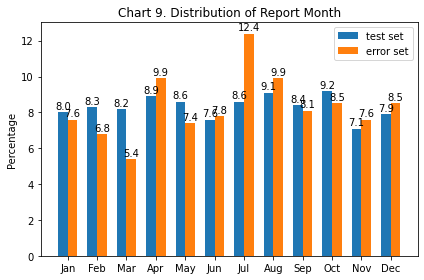

In [ ]:
# Use bar chart to compare distribution of report month
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
test_mon = [8.0, 8.3, 8.2, 8.9, 8.6, 7.6, 8.6, 9.1, 8.4, 9.2, 7.1, 7.9]
error_mon = [7.6, 6.8, 5.4, 9.9, 7.4, 7.8, 12.4, 9.9, 8.1, 8.5, 7.6, 8.5]

x = np.arange(len(labels))  # the label locations
width = 0.33  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, test_mon, width, label='test set')
rects2 = ax.bar(x + width/2, error_mon, width, label='error set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Chart 9. Distribution of Report Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# Descriptive analysis on error dataset
# 2. Compare Distribution of child's physical/mental issue
# Error rate is slightly higher for disabled children
print(abuse_test["child_mental_physical"].value_counts()/len(abuse_test)*100)
print(error["child_mental_physical"].value_counts()/len(error)*100)

2    89.940828
1    10.059172
Name: child_mental_physical, dtype: float64
2    81.61157
1    18.38843
Name: child_mental_physical, dtype: float64


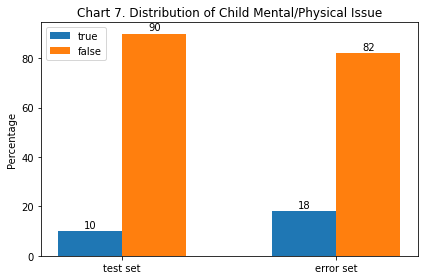

In [ ]:
# Use bar chart to compare distribution of child's physical/mental issue
labels = ['test set', 'error set']
true = [10, 18]
false = [90, 82]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true, width, label='true')
rects2 = ax.bar(x + width/2, false, width, label='false')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Chart 7. Distribution of Child Mental/Physical Issue')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
# Descriptive analysis on error dataset
# 3. Compare Distribution of case_result_double_abuse
# Error rate of single and double_abuse is high
print(abuse_test["case_result_single_abuse"].value_counts()/len(abuse_test)*100)
print(abuse_test["case_result_double_abuse"].value_counts()/len(abuse_test)*100)
print(abuse_test["case_result_triple_abuse"].value_counts()/len(abuse_test)*100)
print(abuse_test["case_result_quad_abuse"].value_counts()/len(abuse_test)*100)
print(error["case_result_single_abuse"].value_counts()/len(error)*100)
print(error["case_result_double_abuse"].value_counts()/len(error)*100)
print(error["case_result_triple_abuse"].value_counts()/len(error)*100)
print(error["case_result_quad_abuse"].value_counts()/len(error)*100)

1    90.203813
0     9.796187
Name: case_result_single_abuse, dtype: float64
0    90.598291
1     9.401709
Name: case_result_double_abuse, dtype: float64
0    99.638396
1     0.361604
Name: case_result_triple_abuse, dtype: float64
0    99.967127
1     0.032873
Name: case_result_quad_abuse, dtype: float64
1    83.884298
0    16.115702
Name: case_result_single_abuse, dtype: float64
0    85.123967
1    14.876033
Name: case_result_double_abuse, dtype: float64
0    98.966942
1     1.033058
Name: case_result_triple_abuse, dtype: float64
0    99.793388
1     0.206612
Name: case_result_quad_abuse, dtype: float64


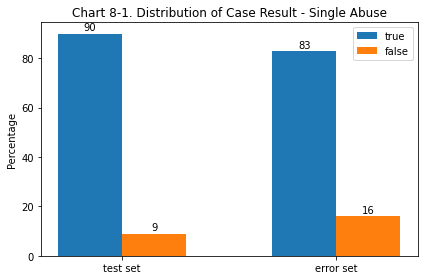

In [ ]:
# Use bar chart to compare distribution of case result - single abuse
labels = ['test set', 'error set']
true = [90, 83]
false = [9, 16]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true, width, label='true')
rects2 = ax.bar(x + width/2, false, width, label='false')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Chart 8-1. Distribution of Case Result - Single Abuse')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

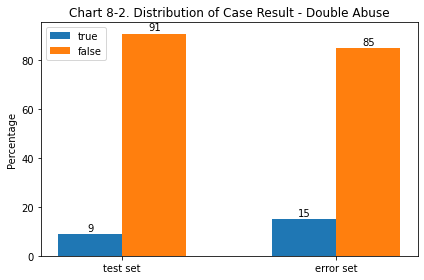

In [ ]:
# Use bar chart to compare distribution of case result - double abuse
labels = ['test set', 'error set']
true = [9, 15]
false = [91, 85]

x = np.arange(len(labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true, width, label='true')
rects2 = ax.bar(x + width/2, false, width, label='false')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Chart 8-2. Distribution of Case Result - Double Abuse')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Extension Task - Fairness Audit 

## Demographic Parity

The first definition of fairness is based on distribution of risk levels. In terms of demographic features **age** and **race**, the classification algorithm is fair if: All groups get the same distribution of high/low risk level. 

In [ ]:
# White and black population take up 98% of the whole data
# This task only look at two races: black and white
print("Distribution of Race")
print(abuse_test.race.value_counts() / len(abuse_test))
print()

Distribution of Race
1    0.667982
2    0.321499
4    0.007232
3    0.003287
Name: race, dtype: float64



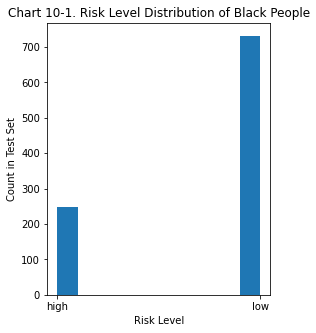

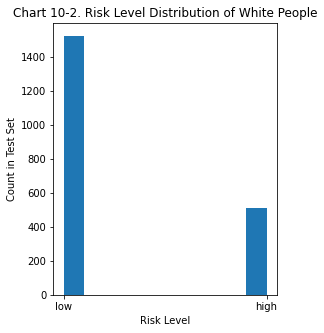

In [ ]:
# Use bar chart to compare distribution between groups
# There is no demographic parity between race groups in the test set.
plt.title("Chart 10-1. Risk Level Distribution of Black People")
black = abuse_test.loc[abuse_test.race == 2]
plt.hist(black.risk_pred)
fig = plt.gcf()
fig.set_size_inches(4,5)
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.show()

plt.title("Chart 10-2. Risk Level Distribution of White People")
white = abuse_test.loc[abuse_test.race == 1]
plt.hist(white.risk_pred)
fig = plt.gcf()
fig.set_size_inches(4,5)
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.show()

In [ ]:
# To see the parity of age, first transform age feature into binary
# Generate binary age feature - preschool (threshold is the mean age, 7 years old)
def preschool(x):
    if x <= 7:
        return 1
    if x > 7:
        return 0
    
abuse_test["preschool"] = abuse["age"].apply(preschool)
abuse_test["preschool"].value_counts()

1    1722
0    1320
Name: preschool, dtype: int64

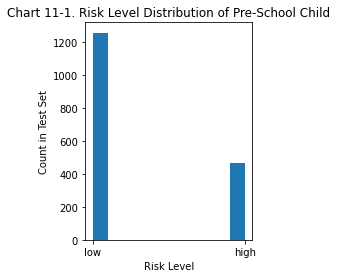

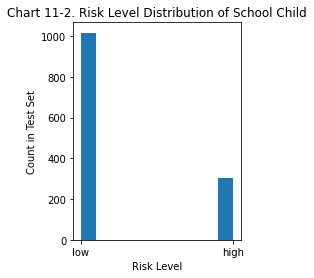

In [ ]:
# There is no demographic parity between age groups in the test set.
plt.title("Chart 11-1. Risk Level Distribution of Pre-School Child")
age_preschool = abuse_test.loc[abuse_test.preschool == 1]
plt.hist(age_preschool.risk_pred)
fig = plt.gcf()
fig.set_size_inches(3,4)
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.show()

plt.title("Chart 11-2. Risk Level Distribution of School Child")
school = abuse_test.loc[abuse_test.preschool == 0]
plt.hist(school.risk_pred)
fig = plt.gcf()
fig.set_size_inches(3,4)
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.show()

## Prevalence 
This step calculate the percentage of each race/age in the dataset.

In [ ]:
# Calculate baseline distributions of risk_pred
print("Distribution of predicted risk level")
print(abuse_test["risk_pred"].value_counts() / len(abuse_test))
print(abuse_test["risk_pred"].value_counts())
print()

Distribution of predicted risk level
low     0.747206
high    0.252794
Name: risk_pred, dtype: float64
low     2273
high     769
Name: risk_pred, dtype: int64



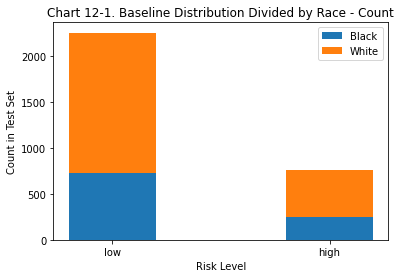

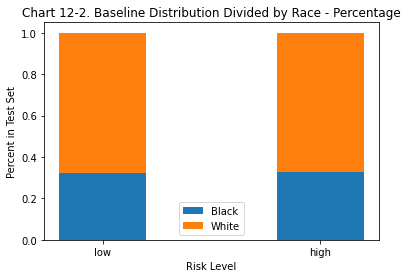

In [ ]:
# Use bar chart to compare count and percentage between race groups.
risk_label = ["low", "high"]
plt.bar(risk_label, black.risk_pred.value_counts(), width=0.4)
plt.bar(risk_label, white.risk_pred.value_counts(), bottom=black.risk_pred.value_counts(), width=0.4)
plt.legend(["Black", "White"])
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.title("Chart 12-1. Baseline Distribution Divided by Race - Count")
plt.show()

black_pcts = black.risk_pred.value_counts() / (black.risk_pred.value_counts() + white.risk_pred.value_counts())
white_pcts = white.risk_pred.value_counts() / (black.risk_pred.value_counts() + white.risk_pred.value_counts())

plt.bar(risk_label, black_pcts, width=0.4)
plt.bar(risk_label, white_pcts, bottom=black_pcts, width=0.4)
plt.legend(["Black", "White"])
plt.xlabel("Risk Level")
plt.ylabel("Percent in Test Set")
plt.title("Chart 12-2. Baseline Distribution Divided by Race - Percentage")
plt.show()

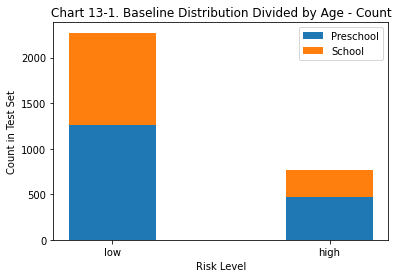

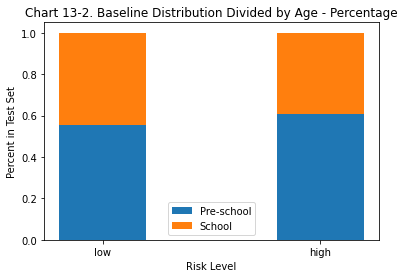

In [ ]:
# Use bar chart to compare count and percentage between age groups.
risk_label = ["low", "high"]
plt.bar(risk_label, age_preschool.risk_pred.value_counts(), width=0.4)
plt.bar(risk_label, school.risk_pred.value_counts(), bottom=age_preschool.risk_pred.value_counts(), width=0.4)
plt.legend(["Preschool", "School"])
plt.xlabel("Risk Level")
plt.ylabel("Count in Test Set")
plt.title("Chart 13-1. Baseline Distribution Divided by Age - Count")
plt.show()

age_preschool_pcts = age_preschool.risk_pred.value_counts() / (age_preschool.risk_pred.value_counts() + school.risk_pred.value_counts())
school_pcts = school.risk_pred.value_counts() / (age_preschool.risk_pred.value_counts() + school.risk_pred.value_counts())

plt.bar(risk_label, age_preschool_pcts, width=0.4)
plt.bar(risk_label, school_pcts, bottom=age_preschool_pcts, width=0.4)
plt.legend(["Pre-school", "School"])
plt.xlabel("Risk Level")
plt.ylabel("Percent in Test Set")
plt.title("Chart 13-2. Baseline Distribution Divided by Age - Percentage")
plt.show()

## Error Rate Parity


However, we will now look more carefully at the modes of failure -- false positives and alse negatives -- separate from one another. This will reveal a different trend in the model's predictions. 

In [ ]:
# confusion matrix of risk_pred
confusion_matrix = pd.crosstab(abuse_test['risk_level'], abuse_test['risk_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  high   low
Actual               
high        500   215
low         269  2058


In [ ]:
# confusion matrix by race
confusion_matrix = pd.crosstab(white['risk_level'], white['risk_pred'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion matrix of White:")
print (confusion_matrix)
print()

confusion_matrix = pd.crosstab(black['risk_level'], black['risk_pred'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion matrix of Black:")
print (confusion_matrix)

Confusion matrix of White:
Predicted  high   low
Actual               
high        337   133
low         174  1388

Confusion matrix of Black:
Predicted  high  low
Actual              
high        159   80
low          88  651


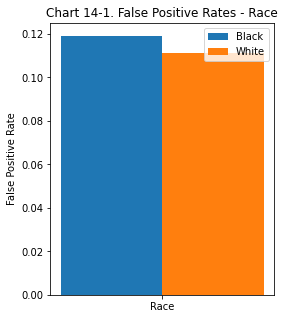

[[0.11907983761840325], [0.11139564660691421]]

In [ ]:
# Calculate error balance of false positives

race_probs = []
for race in [black, white]:
  probs = []
  risk_label = ["Race"]
  for risk in risk_label:
    subset = race.loc[race.risk_level=='low']
    false_positive = subset.loc[subset.risk_pred == 'high']
    false_positive_rate = len(false_positive) / len(subset)
    probs.append(false_positive_rate)
  race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(4,5)
plt.bar(risk_label, race_probs[0], align='edge', width=-.1)
plt.bar(risk_label, race_probs[1], align='edge', width=.1)
plt.xticks(ticks=risk_label, labels=risk_label)
plt.ylabel("False Positive Rate")
plt.legend(["Black", "White"])
plt.title("Chart 14-1. False Positive Rates - Race")
plt.show()
race_probs

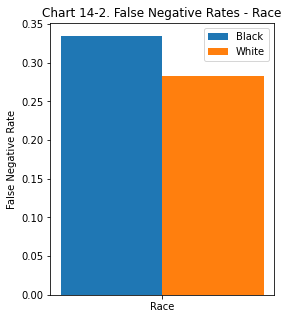

[[0.33472803347280333], [0.28297872340425534]]

In [ ]:
# Calculate error balance of false negatives

race_probs = []
for race in [black, white]:
  probs = []
  for risk in risk_label:
    subset = race.loc[race.risk_level=='high']
    false_negative = subset.loc[subset.risk_pred == 'low']
    false_negative_rate = len(false_negative) / len(subset)
    probs.append(false_negative_rate)
  race_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(4,5)
plt.bar(risk_label, race_probs[0], align='edge', width=-.1)
plt.bar(risk_label, race_probs[1], align='edge', width=.1)
plt.xticks(ticks=risk_label, labels=risk_label)
plt.ylabel("False Negative Rate")
plt.legend(["Black", "White"])
plt.title("Chart 14-2. False Negative Rates - Race")
plt.show()
race_probs


In [ ]:
# confusion matrix by age-preschool
confusion_matrix = pd.crosstab(age_preschool['risk_level'], age_preschool['risk_pred'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion matrix of preschool:")
print (confusion_matrix)
print()

confusion_matrix = pd.crosstab(school['risk_level'], school['risk_pred'], rownames=['Actual'], colnames=['Predicted'])
print("Confusion matrix of school:")
print (confusion_matrix)

Confusion matrix of preschool:
Predicted  high   low
Actual               
high        317   121
low         149  1135

Confusion matrix of school:
Predicted  high  low
Actual              
high        183   94
low         120  923


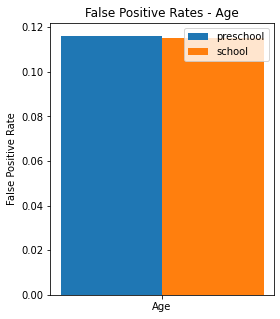

[[0.11604361370716511], [0.11505273250239693]]

In [ ]:
# Calculate error balance of false positives

ages_probs = []
for ages in [age_preschool, school]:
  probs = []
  risk_label = ["Age"]
  for risk in risk_label:
    subset = ages.loc[ages.risk_level=='low']
    false_positive = subset.loc[subset.risk_pred == 'high']
    false_positive_rate = len(false_positive) / len(subset)
    probs.append(false_positive_rate)
  ages_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(4,5)
plt.bar(risk_label, ages_probs[0], align='edge', width=-.1)
plt.bar(risk_label, ages_probs[1], align='edge', width=.1)
plt.xticks(ticks=risk_label, labels=risk_label)
plt.ylabel("False Positive Rate")
plt.legend(["preschool", "school"])
plt.title("False Positive Rates - Age")
plt.show()
ages_probs

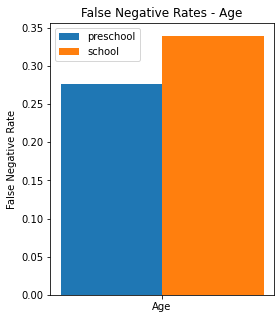

[[0.2762557077625571], [0.33935018050541516]]

In [ ]:
# Calculate error balance of false negatives

ages_probs = []
for ages in [age_preschool, school]:
  probs = []
  for risk in risk_label:
    subset = ages.loc[ages.risk_level=='high']
    false_negative = subset.loc[subset.risk_pred == 'low']
    false_negative_rate = len(false_negative) / len(subset)
    probs.append(false_negative_rate)
  ages_probs.append(probs)

fig = plt.gcf()
fig.set_size_inches(4,5)
rects1 = plt.bar(risk_label, ages_probs[0], align='edge', width=-.1)
rects2 = plt.bar(risk_label, ages_probs[1], align='edge', width=.1)
plt.xticks(ticks=risk_label, labels=risk_label)
plt.ylabel("False Negative Rate")
plt.legend(["preschool", "school"])
plt.title("False Negative Rates - Age")
plt.show()
ages_probs

